<a href="https://colab.research.google.com/github/shivani-nandani/emotion-detection/blob/main/BEST_jaffe_pca_svm_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

reference - [https://radiant-brushlands-42789.herokuapp.com/towardsdatascience.com/building-a-facial-recognition-model-using-pca-svm-algorithms-c81d870add16](https://radiant-brushlands-42789.herokuapp.com/towardsdatascience.com/building-a-facial-recognition-model-using-pca-svm-algorithms-c81d870add16)

In [2]:
import pylab as pl
import numpy as np
import os
import cv2
from matplotlib import pyplot as plt
import matplotlib.image as mplib 
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.svm import SVC

In [109]:
img_data_list=[]
label_dict = {'AN': 0, 'DI': 1, 'FE': 2, 'HA': 3, 'NE': 4, 'SA': 5, 'SU': 6}
labels = []
directory = '/content/drive/MyDrive/JAFFE'

for img in os.listdir(directory):
    input_img = cv2.imread(directory+'/'+img)
    input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
    img_data_list.append(input_img)
    labels.append(label_dict[img.split('.')[1][:2]])
        
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data/255

n_samples, h, w = img_data.shape
np.random.seed(42)

img_data = img_data.reshape(n_samples,-1)
labels = np.array(labels)

names = ['anger','disgust','fear','happy','neutral','sadness','surprise']

num_classes = len(names)

def getLabel(id):
    return ['anger','disgust','fear','happy','neutral','sadness','surprise'][id]

img_data.shape, labels.shape

((213, 65536), (213,))

In [110]:
Y = np_utils.to_categorical(labels, num_classes)
y = labels
X_train, X_test, y_train, y_test = train_test_split(img_data, y, test_size=0.20, shuffle=True, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((170, 65536), (170,), (43, 65536), (43,))

In [111]:
n_components = 130
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
sum(pca.explained_variance_ratio_)

0.9877740951487795

In [112]:
eigenfaces = pca.components_.reshape((n_components, h, w))
eigenfaces.shape

(130, 256, 256)

In [113]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
X_train_pca.shape, X_test_pca.shape

((170, 130), (43, 130))

In [114]:
print("Fitting the classifier to the training set")
param_grid = {
    'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 1e1, 5e1, 1e2, 5e2, 1e3, 5e3, 1e4, 5e4, 1e5, 5e5, 1e6],
    'gamma': [1e-8, 5e-8, 1e-7, 5e-7, 1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2],
}
clf = GridSearchCV(SVC(kernel='sigmoid', class_weight='balanced'),
param_grid)
clf = clf.fit(X_train_pca, y_train)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=5, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [115]:
print("Predicting the people names on the testing set")
y_pred = clf.predict(X_test_pca)

Predicting the people names on the testing set


In [116]:
print(classification_report(y_test, y_pred, target_names=names))

              precision    recall  f1-score   support

       anger       1.00      0.89      0.94         9
     disgust       1.00      1.00      1.00         7
        fear       0.80      1.00      0.89         4
       happy       1.00      0.83      0.91         6
     neutral       0.80      1.00      0.89         4
     sadness       1.00      1.00      1.00         7
    surprise       1.00      1.00      1.00         6

    accuracy                           0.95        43
   macro avg       0.94      0.96      0.95        43
weighted avg       0.96      0.95      0.95        43



In [117]:
print(confusion_matrix(y_test, y_pred, labels=range(num_classes)))

[[8 0 0 0 1 0 0]
 [0 7 0 0 0 0 0]
 [0 0 4 0 0 0 0]
 [0 0 1 5 0 0 0]
 [0 0 0 0 4 0 0]
 [0 0 0 0 0 7 0]
 [0 0 0 0 0 0 6]]


In [118]:
def title(y_pred, y_test, target_names, i):
    pred_name = names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue: %s' % (pred_name, true_name)

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

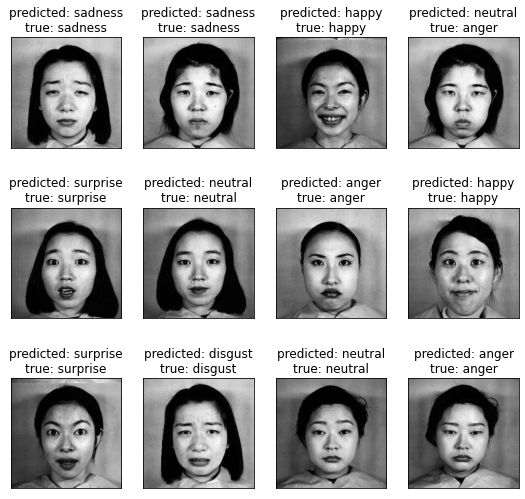

In [119]:
prediction_titles = [title(y_pred, y_test, names, i) for i in range(y_pred.shape[0])]
plot_gallery(X_test, prediction_titles, h, w)

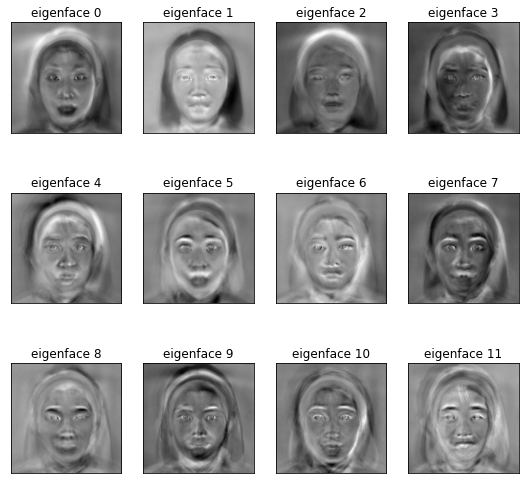

In [120]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

In [121]:
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, y_pred)
print(score)

0.9534883720930233


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
